In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
from sklearn.model_selection import train_test_split
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')
# import multiprocessing
# To set start method safely (only once, at top of script/notebook)
# multiprocessing.set_start_method('spawn', force=True)

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


## 1. Configurations

In [84]:
data_dir = Path("C:/Users/idris_oduola/Documents/Projects/FWI/dataset/train_samples/FlatFault_B")
for file in data_dir.iterdir():
    print(file)

C:\Users\idris_oduola\Documents\Projects\FWI\dataset\train_samples\FlatFault_B\seis6_1_0.npy
C:\Users\idris_oduola\Documents\Projects\FWI\dataset\train_samples\FlatFault_B\seis8_1_0.npy
C:\Users\idris_oduola\Documents\Projects\FWI\dataset\train_samples\FlatFault_B\vel6_1_0.npy
C:\Users\idris_oduola\Documents\Projects\FWI\dataset\train_samples\FlatFault_B\vel8_1_0.npy


In [3]:
folder = Path("C:/Users/idris_oduola/Documents/Projects/FWI/dataset/test")
file_count = sum(1 for f in folder.iterdir() if f.is_file())
print(f"Total files: {file_count}")

Total files: 13


In [135]:
class config:
    def __init__(self):
        #The File paths
        self.train_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/train_samples'
        self.test_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/test'
        self.test_num = sum(1 for f in folder.iterdir() if f.is_file())
        print(f'The number of files in test data is: {self.test_num}') 
        #self.submission_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/sample_submission.csv'
        self.model_path = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/fwi_model.pt'
        self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/FWI/dataset/checkpoint_fwi'
        self.dset1 = ["FlatVel_A","FlatVel_B", "Style_A", "Style_B","CurveVel_A","CurveVel_B"] #Dataset storage names used for training
        self.dset2 = ["FlatFault_A", "FlatFault_B", "CurveFault_A"]

        #Model Parameters
        self.init_channels = 5
        self.final_channel = 1
        self.depth = 4
        self.base_channel = 64
        
        
        #Optimizer
        self.lr = 0.001
        self.weight_decay = 1e-4 #Regularization weight
        
        #The training parameters
        self.num_epoch = 100
        self.batch_size = 50

        #Learning rate scheduler
        self.step_size = 10  #To decay after every, say 10 epochs
        self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

        

cfg = config()

The number of files in test data is: 13


### 1.1 Preparing the Data

In [136]:
#Pytorch Dataset for DataLoader, we set velocity initially to None in the case of loading the test set
#Note: We can also use the TensorDataset from torch.utils.data
class SeismicDataset(Dataset):
    def __init__(self, seismic, vel = None):
        self.seismic = torch.tensor(seismic, dtype = torch.float32)
        self.label = vel is not None
        if self.label:
            self.vel = torch.tensor(vel, dtype = torch.float32)

    def __len__(self):
        return len(self.seismic)

    def __getitem__(self,idx):
        if self.label:
            return self.seismic[idx], self.vel[idx]
        else:
            return self.seismic[idx]

In [137]:

def prepare_data(cfg):
    #First we extract the velocity and seismic data's for training and testing
    vel_data = []; seismic_data = []; test_data = []

    #Extracting and concatenating the training data
    for domain in cfg.dset1: 
        model_path = Path(cfg.train_path) / domain / "model"
        data_path = Path(cfg.train_path) / domain / "data"
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("*.npy"))]
    
    for domain in cfg.dset2: 
        model_path = Path(cfg.train_path) / domain 
        data_path = Path(cfg.train_path) / domain
    
        # Load all .npy files in this domain and extend the master lists
        vel_data += [np.load(str(f)) for f in sorted(model_path.glob("vel*.npy"))]
        seismic_data += [np.load(str(f)) for f in sorted(data_path.glob("seis*.npy"))]

    
    # Concatenate all at once
    sample_points = sum(v.shape[0] for v in vel_data) #To ensure we have the required number of data
    vel_data = np.concatenate(vel_data, axis=0)
    vel_data = (vel_data - vel_data.mean())/(vel_data.std() + 1e-8)
    seismic_data = np.concatenate(seismic_data, axis=0)
    assert ( vel_data.shape[0] == sample_points and seismic_data.shape[0] == sample_points
           ), f"Expected sample size {sample_points} but got {vel_data.shape[0]} and {seismic_data.shape[0]}"
    print(f"Training data --> Seismic: {seismic_data.shape}, Velocity: {vel_data.shape}")

    #We need to normalize (Z-score) our input before training
    #s_mean = seismic_data.mean(axis=(0, 2, 3), keepdims=True); s_std = seismic_data.std(axis=(0, 2, 3), keepdims=True)
    #seismic_data = (seismic_data - s_mean)/(s_std + 1e-6) #Epsilon is for stability

    #Extracting the Test data
    test_path = Path(cfg.test_path)
    test_data += [np.load(str(f)) for f in sorted(test_path.glob("*.npy"))[0:cfg.test_num]] #Only first few for illustration
    test_sample_points = sum(v.shape[0] for v in test_data)
    test_data = np.concatenate(test_data,axis=0)
    test_data = (test_data - test_data.mean())/(test_data.std() + 1e-8)
    test_data = np.expand_dims(test_data, axis=1)
    test_data = np.repeat(test_data, 5, axis=1)
    assert test_data.shape[0] == test_sample_points, f"Expected test size {test_sample_points} but got {test_data.shape[0]} "
    print(f"Testing data --> Seismic: {test_data.shape}")

    #Next, we take a portion of the train data for validation
    X_train, X_val, y_train,y_val = train_test_split(
        seismic_data, vel_data, test_size = 0.1, random_state = 42, shuffle = True
    )
    print(f"After split --> X_train: {X_train.shape}, y_train: {y_train.shape} -- X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    #Loading the datasets into batches
    train_dataset = SeismicDataset(X_train, y_train)
    val_dataset = SeismicDataset(X_val, y_val)
    test_dataset = SeismicDataset(test_data)

    #DataLoader
    train_loader = DataLoader(train_dataset, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader 


In [138]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader = prepare_data(self.cfg)
        print('DataLoaded Successfully!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader
    
    def predict_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)

In [139]:
data_module.setup()

Training data --> Seismic: (9000, 5, 1000, 70), Velocity: (9000, 1, 70, 70)
Testing data --> Seismic: (65, 5, 1000, 70)
After split --> X_train: (8100, 5, 1000, 70), y_train: (8100, 1, 70, 70) -- X_val: (900, 5, 1000, 70), y_val: (900, 1, 70, 70)
DataLoaded Successfully!


In [131]:
batch = next(iter(data_module.predict_dataloader()))
print("Test batch:", type(batch), batch.shape)


Test batch: <class 'torch.Tensor'> torch.Size([50, 5, 1000, 70])


## 2. The U-Net Model
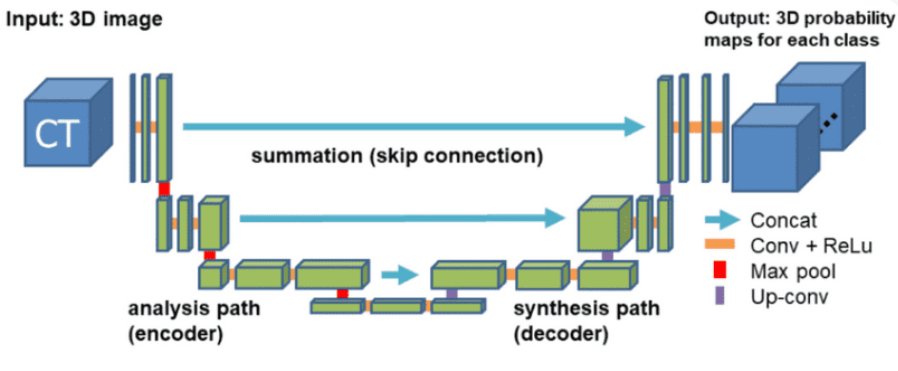

[https://theaisummer.com/unet-architectures/](http://)

In [148]:
#First we define a multi convolutional layer block in the encoder
#If we wish, we may set the middle channels to be same as the output channel
#Lastly, we will take the number of sources of number of channels, so that in_channels = 5 initially
class multiConv(nn.Module):
    def __init__(self, in_channels, out_channels, n_conv=3, mid_channels = None):
        """
        n_conv*( conv --> batchnorm --> ReLU)
        """
        super().__init__()
        mid_channels = mid_channels or out_channels
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1, bias = False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace = True)
            )

        layers = [conv_block(in_channels, mid_channels)]
        layers += [conv_block(mid_channels, mid_channels) for _ in range(n_conv - 2)]
        layers += [conv_block(mid_channels, out_channels)]

        self.block = nn.Sequential(*layers)

    def forward(self,x):
        return self.block(x)

In [149]:
#Next we define the layer in the encoder block that downsizes the resolution (just a maxpool)
class DownLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            multiConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block(x)

#Now we define the layer in the decoder block that upscales the resolution
#We only use the bilinear mode. Other modes can be utilized!
#While Upscaling, residuals from the encoder is added
class UpLayer(nn.Module):
    def __init__(self,decoder_channels,encoder_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        in_channels = decoder_channels + encoder_channels #To ensure safer handling of the channels
        self.conv = multiConv(in_channels, out_channels, mid_channels = in_channels//2 )

    def forward(self, x1, x2): #x2 is from the encoder block
        x1 = self.up(x1)
        #Padding to ensure alignment of shapes
        y_diff = x2.size()[2] - x1.size()[2]
        x_diff = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [x_diff//2, x_diff - x_diff//2, y_diff//2, y_diff - y_diff//2])
        x = torch.cat([x1,x2], dim = 1)
        return self.conv(x)

#Lastly, we define the final output convolution layer
class outConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)

### 2.1 Bringing all Together

So basically, our model should be:

**input --> 2xconv_block --> 4x(down --> 3xconv_block) --> 2xconv_block --> 4x(up --> 3xconv_block) -->sigmoid(out_conv)**

#### Attention!!

The issue here is that the output of the U-Net is (batch, 1, 1000, 70), having the same resolution as the seismic data, which is in contrast to the velocity data, of shape (batch, 1, 70, 70). 

There are many ways to resolve this:

* We can correct this by flattening the output, pass into fully connected layers, then reshape to the velocity data's shape. This means that we are letting the UNet extract spatiotemporal features from seismic input, and then using a fully connected head to learn the mapping to our target structured velocity map. However, the flattened U-Net output is very large (i.e., 1000 × 70 = 70,000), and so the first FC layer can be memory-heavy.

* Another approach is to apply a conv layer to learn channel transformations at high resolution, then apply adaptive average pooling to compress it to a manageable size. We will be utilizing this, since it is more memory efficient.

In [150]:
class UNet(nn.Module):
    def __init__(self, channels_init, final_channel, depth = 4, base_channel = 64):
        """
        depth: #No of downsizing and upscaling
        channels_init: Initial #no of channels from data
        final_channel: Final #no of channels corresponding to target data
        base_channel: output channel after the first convolution
        """
        super().__init__()
        self.depth = depth

        #Initial multiconvolution before downsizing
        self.init_conv = multiConv(channels_init, base_channel, 2)

        #The encoder block (consist of depths number of downsizing blocks/layers)
        self.encoder_block = nn.ModuleList()
        encoder_channels = [base_channel]
        channel = base_channel
        for _ in range(self.depth):
            self.encoder_block.append(DownLayer(channel, channel*2))
            channel *= 2 #Increase number of channels after downsizing
            encoder_channels.append(channel)

        #The Bottleneck or connection
        self.bottleneck = multiConv(channel, channel, 2)

        #The decoder block (consist of depths number of upscaling blocks/layers)
        self.decoder_block = nn.ModuleList()
        for i in range(self.depth):
            skip_channel = encoder_channels[-(i+2)]
            self.decoder_block.append(UpLayer(channel,skip_channel, skip_channel))
            channel = skip_channel #Ensure the number of channels for the residual connection are the same

        #The Final output convolution
        self.out_conv = outConv(channel, final_channel)
        self.final_conv = outConv(final_channel, final_channel)
        self.pool = nn.AdaptiveAvgPool2d((70, 70))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        #We need to store the outputs from the encoder block
        #It is needed in the decoder as residuals
        res = []
        x = self.init_conv(x)
        res.append(x)

        #Encoder
        for down_block in self.encoder_block:
            x = down_block(x)
            res.append(x)

        #Bottleneck
        x = self.bottleneck(res.pop()) #The last output is what is needed for the bottleneck, but will not be used as a residual

        #Decoder
        for up_block in self.decoder_block:
            x2 = res.pop() #Reverse residual list
            x = up_block(x,x2)

        #Final Convolution and downscaling resolution to be same as target variable
        x = self.out_conv(x) #(Batch, base_channel, 1000, 70) --> (Batch, 1, 1000, 70)
        x = self.final_conv(x) #(Batch, 1, 1000, 70) --> (Batch, 1, 1000, 70)
        x = self.pool(x)  #(Batch, 1, 1000, 70) --> (Batch, 1, 70, 70)
        out = self.final_conv(x) #(Batch, 1, 70, 70)
        
        return self.activation(out)

## 3. Training

In [151]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = UNet(cfg.init_channels, cfg.final_channel, cfg.depth, cfg.base_channel)
        self.metrics = {'train_loss':[], 'val_loss':[]}

    def forward(self,x):
        return self.model(x)

    def _common_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self.model(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = F.l1_loss(y_hat,y)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._common_step(batch, batch_idx)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch,batch_idx):
        x = batch.to(self.device)
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]
    

    def evaluate_on_exact_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = F.l1_loss(y_hat, y)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        print(f"Average L1 Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, predictions, targets

    #            

In [152]:
#Training the model
model = PlModel(cfg)

checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'fwi-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min'
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training data --> Seismic: (9000, 5, 1000, 70), Velocity: (9000, 1, 70, 70)
Testing data --> Seismic: (65, 5, 1000, 70)
After split --> X_train: (8100, 5, 1000, 70), y_train: (8100, 1, 70, 70) -- X_val: (900, 5, 1000, 70), y_val: (900, 1, 70, 70)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


DataLoaded Successfully!



  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 76.1 M | train
---------------------------------------
76.1 M    Trainable params
0         Non-trainable params
76.1 M    Total params
304.492   Total estimated model params size (MB)
161       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 162/162 [03:33<00:00,  0.76it/s, v_num=5, train_loss_step=0.638, val_loss_step=0.604, val_loss_epoch=0.645, train_loss_epoch=0.618]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 162/162 [03:33<00:00,  0.76it/s, v_num=5, train_loss_step=0.638, val_loss_step=0.604, val_loss_epoch=0.645, train_loss_epoch=0.618]


### Evaluation

In [153]:
#First load best model with validation in checkpoint
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("fwi-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.predict_dataloader()
predictions = trainer.predict(model, dataloaders=pred_loader)

Training data --> Seismic: (9000, 5, 1000, 70), Velocity: (9000, 1, 70, 70)
Testing data --> Seismic: (65, 5, 1000, 70)
After split --> X_train: (8100, 5, 1000, 70), y_train: (8100, 1, 70, 70) -- X_val: (900, 5, 1000, 70), y_val: (900, 1, 70, 70)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\idris_oduola\Documents\Projects\FWI\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


DataLoaded Successfully!
Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


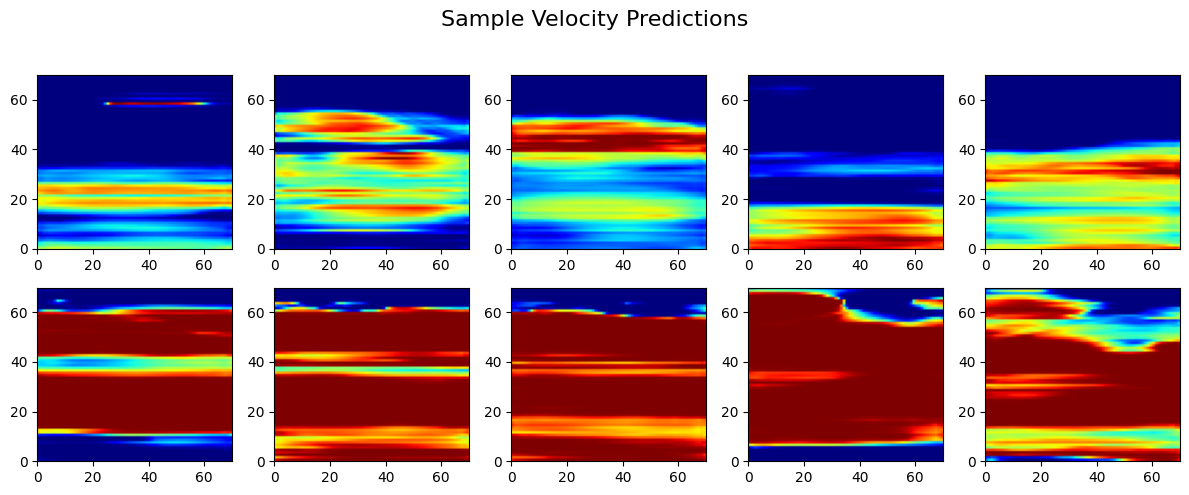

In [155]:
plt.figure(figsize=(12, 5))
plt.suptitle("Sample Velocity Predictions", fontsize=16)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(predictions[0][i].squeeze(), cmap='jet', extent=[0, 70, 0, 70], aspect='auto')
    plt.axis("on")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # prevent suptitle from overlapping
plt.show()


In [161]:
#new_path =  Path(cfg.train_path) / "FlatFault_B"
seismic_test = np.load(str(Path(cfg.train_path)/"CurveFault_B/seis6_1_0.npy"))
vel_test = np.load(str(str(Path(cfg.train_path)/"CurveFault_B/vel6_1_0.npy")))
vel_test = (vel_test - vel_test.mean())/(vel_test.std() + 1e-8)
print(f"Seismic: {seismic_test.shape}, Velocity: {vel_test.shape}")

exact_test = SeismicDataset(vel_test)
exact_train_loader = DataLoader(SeismicDataset(seismic_test), batch_size = cfg.batch_size, shuffle = False)
exact_test_loader = DataLoader(SeismicDataset(vel_test), batch_size = cfg.batch_size, shuffle = False)

Seismic: (500, 5, 1000, 70), Velocity: (500, 1, 70, 70)


In [162]:
exact_train_loader = DataLoader(SeismicDataset(seismic_test), batch_size = cfg.batch_size, shuffle = False)
exact_test_loader = DataLoader(SeismicDataset(vel_test), batch_size = cfg.batch_size, shuffle = False)
exact_both_loader = DataLoader(SeismicDataset(seismic_test,vel_test), batch_size = cfg.batch_size, shuffle = False)

In [163]:
model = PlModel.load_from_checkpoint(checkpoint_path, cfg=cfg)
avgloss, preds, exact = model.evaluate_on_exact_test_set(exact_both_loader)

Average L1 Loss on exact test set: 0.7152


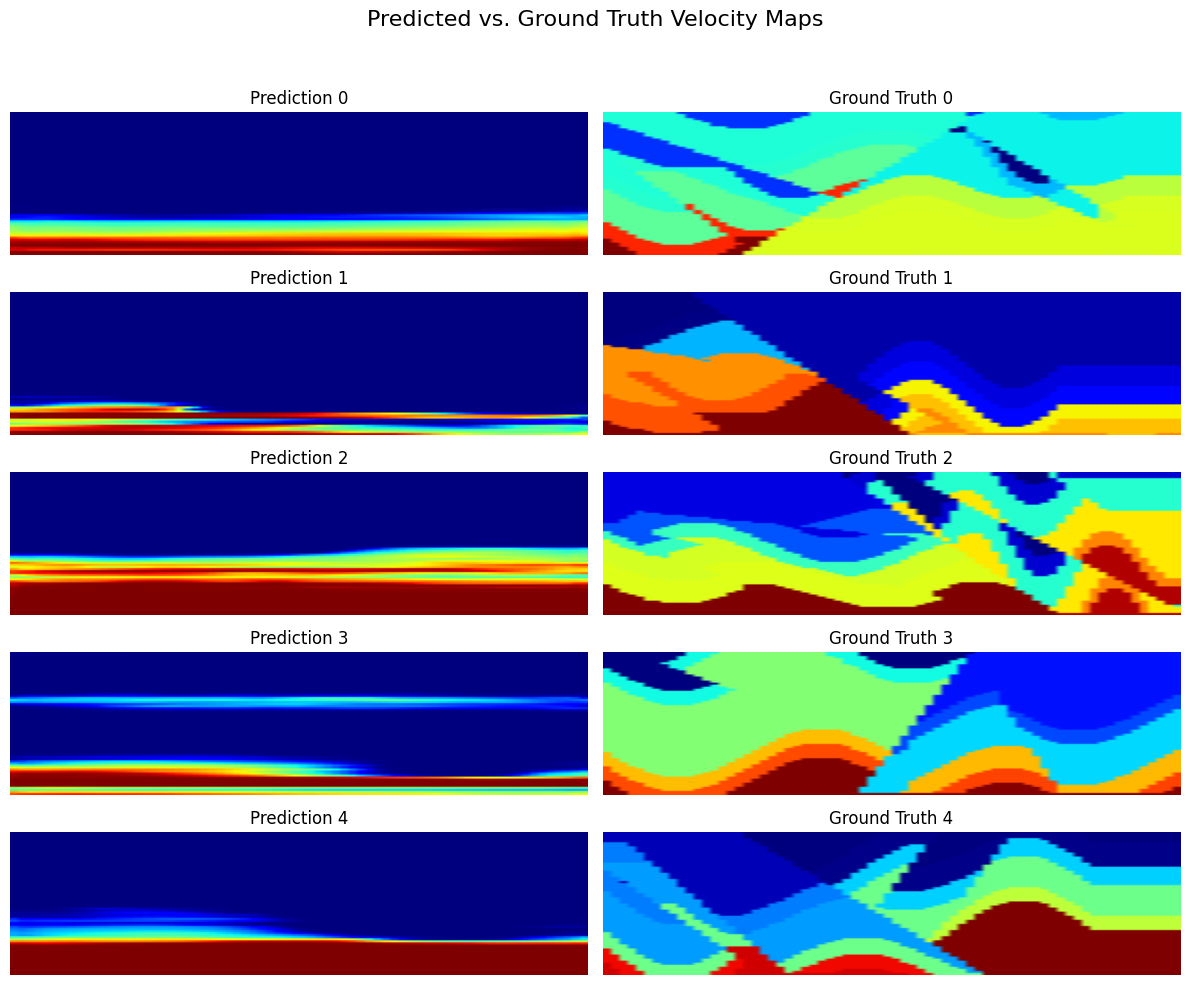

In [164]:
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth Velocity Maps", fontsize=16)

for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[1][i].squeeze().cpu().numpy(), cmap='jet', extent=[0, 70, 70, 0], aspect='auto')
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[1][i].squeeze(), cmap='jet', extent=[0, 70, 70, 0], aspect='auto')
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
